# Fundamentals of Data Science - Week 2 and Week 3

# Assignment
### This assignment should result in a report following the report guidelines found on Blackboard.
### Due date: <u><b style='color: red'>  27.09.2017 (Wednesday) at 23:55 CEST </b></u>

So far we have covered the following sections:

+ Basic Python development
+ Pandas data management
+ Gathering data (scraping the Twitter Streaming API)
+ Storing and organizing it (store to file or a database)
+ Preprocessing the data
+ Performing sentiment and topical analysis
+ Visualizing insight

Given the newly acquired skills, your assignment is to perform an analysis on a dataset of tweets already provided in the course. The analysis should contain topic modelling and sentiment analysis. Use different splits of the data you have to perform your analysis, compare, correlate and visualize.

The dataset can be found on this link in the <i>tweets</i> folder:

[Dataset + SentiStrenght](https://www.dropbox.com/sh/9vqjouzdroj45dt/AABeoQwVfwEMrvgA1qDtDE3ia?dl=0)

All of the tweets have geolocation on them so it would be natural to show the geographical distribution of the analysis you performed on the map you designed in Week 1 of the course. When visualizing the results of your analysis keep in mind that you can change the size, color, location or even boundries of the map. You can also hide and show regions depending on what is the point you are trying to make.

Make sure to correlate the findings with:
+ Demographics
+ Education
+ Income
+ Health care
+ Religion

This information can be obtained from the sources mentioned in the lectures.

As an additional resource to help with the sentiment analysis, there is a Java based utility in the same folder named SentiStrenght. You can use this to confirm your results or as an additional case study.

***

___


# Introduction

This file integrates pretrained models and results from topic modelling and sentiment analysis (which can be found in different notebooks of the same GitHub repository) and concludes in our final results

## Load data

If MongoDB is installed on your device and a database named Twitter is created, the tweets can be stored as database entries using the following code:

**Note**: If Mongo is not installed on your device it will yield a Connection Refused exception.

In [1]:
from pymongo import MongoClient
from pprint import pprint
client = MongoClient()
db = client.Twitter

In [2]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
start_time = time.time()
#we are filtering out tweets of different languages and outside of the US
filter_query = { 
    "$and":[ {"place.country_code":"US"}, { "lang": "en" } ]
    }
#we are keeping only our fields of interest
columns_query = {
    'text':1,
    'entities.hashtags':1,
    'entities.user_mentions':1,
    'place.full_name':1,
    'place.bounding_box':1
}

tweets = pd.DataFrame(list(db.tweets.find(
    filter_query, 
    columns_query
    )#.limit()
                               )
                          )

elapsed_time = time.time() - start_time
print elapsed_time


16.6874201298


In [4]:
tweets.drop(['_id'],axis=1,inplace=True)

In [5]:
tweets.head()

,entities,place,text
0,"{u'user_mentions': [{u'id': 813286, u'indices'...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...
1,"{u'user_mentions': [], u'hashtags': [{u'indice...","{u'bounding_box': {u'type': u'Polygon', u'coor...",#CNN #newday clear #Trump deliberately throwin...
2,"{u'user_mentions': [{u'id': 4852163069, u'indi...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@mike4193496 @realDonaldTrump I TOTALLY CONCUR...
3,"{u'user_mentions': [{u'id': 1339835893, u'indi...","{u'bounding_box': {u'type': u'Polygon', u'coor...",@HillaryClinton you ARE the co-founder of ISIS...
4,"{u'user_mentions': [{u'id': 25073877, u'indice...","{u'bounding_box': {u'type': u'Polygon', u'coor...","@realDonaldTrump, you wouldn't recognize a lie..."


In [6]:
print len(tweets)

517724


** Extract data we need into their own columns (links, mentions, hashtags) **

* Deal with links

In [7]:
import re

# A function that extracts the hyperlinks from the tweet's content.
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# A function that checks whether a word is included in the tweet's content
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [8]:
tweets['link'] = tweets['text'].apply(lambda tweet: extract_link(tweet))
tweets['text'] = tweets['text'].apply(lambda tweet: re.sub(r"http\S+", "", tweet))


* Deal with hashtags & mentions

In [9]:
#Functions to extract hashtags and mentions from entities
def extract_hashtags(ent):
    a=[]
    [a.append(hasht['text'].lower()) for hasht in ent['hashtags']]
    #[a.append(hasht['text']) for hasht in ent['hashtags']]
    return a
def extract_mentions(ent):
    users=[]
    [users.append(usr_ment['screen_name'].lower()) for usr_ment in ent['user_mentions']]
    #[users.append(usr_ment['screen_name']) for usr_ment in ent['user_mentions']]
    return users

In [10]:
tweets['hashtags'] = map(extract_hashtags,tweets['entities'])
tweets['mentions'] = map(extract_mentions,tweets['entities'])
tweets.drop(['entities'],axis=1,inplace=True)

In [11]:
tweets['state'] = map(lambda place_dict: place_dict['full_name'][-2:] ,tweets['place'])
tweets['geography'] = map(lambda place_dict: place_dict['bounding_box'] ,tweets['place'])
tweets.drop(['place'],axis=1,inplace=True)

** Convert all text to lowercase **

In [12]:
#make all text lowercase
tweets['text'] = tweets.text.apply(lambda x: x.lower())

In [14]:
tweets.head()

,text,link,hashtags,mentions,state,geography
0,@barackobama \n@fbi\n@lorettalynch \nall in co...,https://t.co/5GMNZq40V3,"[nojustice, trumppence]","[barackobama, fbi, lorettalynch, realdonaldtrump]",LA,"{u'type': u'Polygon', u'coordinates': [[[-91.2..."
1,#cnn #newday clear #trump deliberately throwin...,,"[cnn, newday, trump, isis]",[],MD,"{u'type': u'Polygon', u'coordinates': [[[-76.7..."
2,@mike4193496 @realdonaldtrump i totally concur...,,[],"[mike4193496, realdonaldtrump]",MD,"{u'type': u'Polygon', u'coordinates': [[[-76.5..."
3,@hillaryclinton you are the co-founder of isis...,,[],[hillaryclinton],TX,"{u'type': u'Polygon', u'coordinates': [[[-97.0..."
4,"@realdonaldtrump, you wouldn't recognize a lie...",https://t.co/pKSQM8yikm,[nevertrump],[realdonaldtrump],CA,"{u'type': u'Polygon', u'coordinates': [[[-116...."


# Find the most active states in Twitter

In [15]:
import os,json

In [16]:
from data.US_states import states #import a useful dictionary containing US states and their abbreviations

In [17]:
import geopandas as gpd
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [18]:
S_DIR = '/home/antonis/ipython notebooks/UvA/Fundamentals of Data Science/utils/US_shape' 
filename = os.path.join(S_DIR, 'states.geojson')
US_shape = gpd.read_file(filename)  #opens the .geojson file as geopandas dataframe
#US.sortlevel
US_shape = US_shape[['STATE_ABBR','geometry']]
US_shape.columns = ['NAME','geometry']
US_shape.set_index("NAME",inplace=True)
US_shape.head()

,geometry
NAME,
HI,(POLYGON ((-160.0738033454681 22.0041773479577...
WA,(POLYGON ((-122.4020153103835 48.2252163723779...
MT,POLYGON ((-111.4754253002074 44.70216236909688...
ME,(POLYGON ((-69.77727626137293 44.0741483685119...
ND,POLYGON ((-98.73043728833767 45.93827137024809...


In [30]:
nr_tweets_perstate = pickle.load(open('results/nr_tweets_perstate.pickle'))

In [19]:
#create dicts to go back and forth from state abbr names
state_abbr_to_name = states
state_name_to_abbr = inv_map = {v: k for k, v in state_abbr_to_name.iteritems()}
state_name_to_abbr['United States'] = 'US'

# Connect results with US CENCUS data

In [20]:
#load US Cencus population data
path = '/home/antonis/ipython notebooks/UvA/Fundamentals of Data Science/Week1/sc-est2016-agesex-civ.csv'
population_data_all = pd.read_csv(path)[['NAME','SEX','AGE','POPEST2016_CIV']]
population_data_all.columns = ['NAME','SEX','AGE','POPULATION2016']
population_data_all['NAME'] = population_data_all['NAME'].apply(lambda x: state_name_to_abbr[x])
population_data_all.tail()

,NAME,SEX,AGE,POPULATION2016
13567,WY,2,82,1095
13568,WY,2,83,998
13569,WY,2,84,916
13570,WY,2,85,6562
13571,WY,2,999,286009


In [21]:
state_data = population_data_all.groupby(by=['NAME'])[['POPULATION2016']].sum()
state_data.head()

,POPULATION2016
NAME,
AK,2880780
AL,19398600
AR,11931988
AZ,27647556
CA,156365812


In [22]:
#get males and females by state

In [23]:
def population_by_gender(population_df,state,gender):
    """Pass as first argument the US census 2016 estimate dataframe
    1 for male, 2 for female, 0 for total population"""
    try:
        state = state_name_to_abbr[state]
    except:
        pass
    return population_df[(population_df.NAME == state) & (population_df.AGE == 999) & ((population_df.SEX == gender))]['POPULATION2016'].iloc[0]

In [24]:
males = pd.Series(map(lambda x:population_by_gender(population_data_all,x,1),state_data.index),index=state_data.index,name='males')
females = pd.Series(map(lambda x:population_by_gender(population_data_all,x,2),state_data.index),index=state_data.index,name='females')

In [25]:
#calculate avg age per state

In [26]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise. Also reference to http://pbpython.com/weighted-average.html.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return float((d * w).sum()) / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [27]:
avg_age = pd.Series(population_data_all[(population_data_all['SEX']==0) & (population_data_all['AGE']!=999)].groupby('NAME').apply(wavg, "AGE", "POPULATION2016"),name='avg_age')

In [31]:
state_data = gpd.GeoDataFrame(pd.concat([state_data,males,females,nr_tweets_perstate,avg_age,US_shape],axis=1,join='inner'))

In [29]:
state_data.index.name="NAME"
US_shape.index.name="NAME"

In [32]:
state_data.head()

,POPULATION2016,males,females,nr_tweets,avg_age,geometry
AK,2880780,369588,350607,888,35.559922,(POLYGON ((-161.3337853466416 58.7332483821643...
AL,19398600,2343978,2505672,4963,38.975781,POLYGON ((-85.07006727561546 31.98070335724909...
AR,11931988,1463406,1519591,1266,38.535537,POLYGON ((-94.46169128436209 34.19676535931296...
AZ,27647556,3426641,3485248,13406,38.507104,POLYGON ((-114.5206273030434 33.02770735822419...
CA,156365812,19358288,19733165,57675,37.405932,(POLYGON ((-121.6652203096974 38.1692853630126...


In [33]:
state_data['tweets_per_capita'] = state_data['nr_tweets']/state_data['POPULATION2016']

# plot some figures

** Scale and move states **

In [34]:
%matplotlib inline
import geopandas as  gpd
import warnings
from shapely.geometry.multipolygon import MultiPolygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

#### Scale and move some states [Alaska, Hawaii] for better visualization

In [35]:
#move scale alaska
a =state_data.loc[state_data.index=="AK"].index[0]

Al = state_data['geometry'][a]
Al_ser = gpd.GeoSeries(Al) #Convert to GeoSeries

Al_scale=Al_ser.scale(xfact=0.5, yfact=0.5,origin='center') #Scales Alaska

#sc_a=ser.buffer(-0.3)
Al_scale=Al_scale.translate(xoff=28, yoff=-39) #Moves Alaska down to the right

b=MultiPolygon(Al_scale.all()) #convert again GeoSeries to a multipolygon
state_data['geometry'][a]=b

/home/antonis/anaconda2/envs/USelections/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
#move scale hawaii
a =state_data.loc[state_data.index=="HI"].index[0]

Al = state_data['geometry'][a]
Al_ser = gpd.GeoSeries(Al) #Convert to GeoSeries

Al_scale=Al_ser.scale(xfact=1.8, yfact=1.8,origin='center') #Scales Alaska

#sc_a=ser.buffer(-0.3)
Al_scale=Al_scale.translate(xoff=53, yoff=0) #Moves Alaska down to the right

b=MultiPolygon(Al_scale.all()) #convert again GeoSeries to a multipolygon
state_data['geometry'][a]=b

/home/antonis/anaconda2/envs/USelections/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


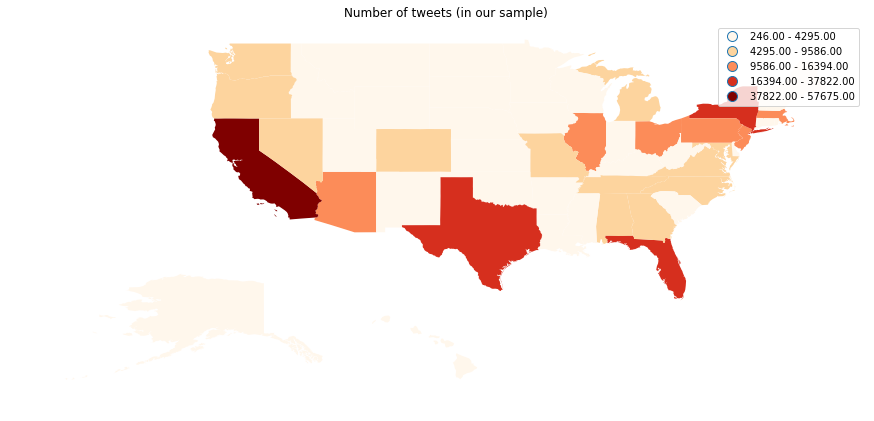

In [37]:
state_data.plot(column='nr_tweets',scheme = 'fisher_jenks',legend=True, cmap='OrRd',figsize=(15,8))
plt.axis('off')
plt.title("Number of tweets (in our sample)")
plt.show()

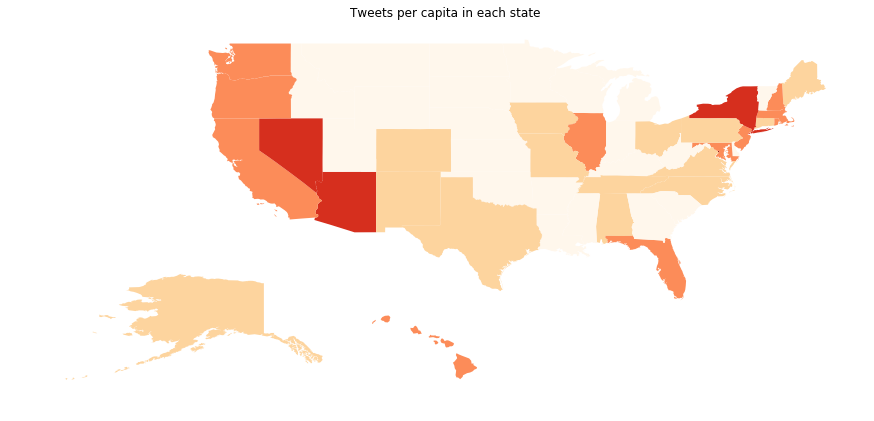

In [38]:
state_data.plot(column='tweets_per_capita',scheme = 'fisher_jenks',legend=False, cmap='OrRd',figsize=(15,8))
plt.axis('off')
plt.title("Tweets per capita in each state")
plt.show()

# election results
2012 and 2016 Presidential Elections data provided by Kaggle.com:
https://www.kaggle.com/benhamner/2016-us-election

In [39]:
demographics = pd.read_csv('data/2012 and 2016 Presidential Elections/county_facts.csv')
demographics = demographics[['area_name','state_abbreviation','RHI825214','EDU635213','EDU685213']]

In [40]:
demographics.head()

,area_name,state_abbreviation,RHI825214,EDU635213,EDU685213
0,United States,NaN,62.1,86.0,28.8
1,Alabama,NaN,66.2,83.1,22.6
2,Autauga County,AL,75.6,85.6,20.9
3,Baldwin County,AL,83.0,89.1,27.7
4,Barbour County,AL,46.6,73.7,13.4


In [41]:
demographics = demographics[(demographics['state_abbreviation'].isnull()) & (demographics['area_name']!='United States')]
try:
    demographics.drop('state_abbreviation',inplace=True)
except:
    pass

In [42]:
def change_to_abbr(name):
    if name=='District Of Columbia':
        return 'DC'
    try:
        return state_name_to_abbr[name]
    except:
        return 'dropme'


In [43]:
demographics['area_name'] = demographics.area_name.apply(lambda x: change_to_abbr(x))

In [44]:
demographics.set_index('area_name',inplace=True)

In [45]:
#add heuristic education score of each state: education_level = 0.5*highschool_level + 1*bachelor_or_higher_level
demographics['Education_score'] = (demographics['EDU635213']-demographics['EDU685213'])*0.5 + demographics['EDU685213']

In [46]:
demographics['non_white_popul'] = 100-demographics['RHI825214']
demographics = demographics[['non_white_popul','Education_score']]
demographics.index.name = 'NAME'

In [47]:
state_data = pd.concat([state_data,demographics],axis=1,join='inner')

In [48]:
state_data.head()

,POPULATION2016,males,females,nr_tweets,avg_age,geometry,tweets_per_capita,non_white_popul,Education_score
AK,2880780,369588,350607,888,35.559922,(POLYGON ((-129.7193510932754 21.1139411334502...,0.000308,38.1,59.55
AL,19398600,2343978,2505672,4963,38.975781,POLYGON ((-85.07006727561546 31.98070335724909...,0.000256,33.8,52.85
AR,11931988,1463406,1519591,1266,38.535537,POLYGON ((-94.46169128436209 34.19676535931296...,0.000106,26.6,51.90
AZ,27647556,3426641,3485248,13406,38.507104,POLYGON ((-114.5206273030434 33.02770735822419...,0.000485,43.8,56.30
CA,156365812,19358288,19733165,57675,37.405932,(POLYGON ((-121.6652203096974 38.1692853630126...,0.000369,61.5,55.95


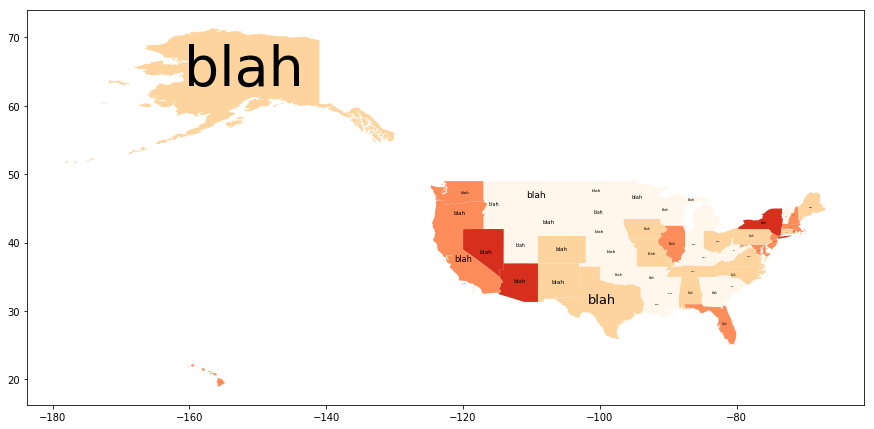

# TODO

# Find the top hashtags

* In all the US

In [49]:
from itertools import chain
hashtags = pd.Series(list(chain.from_iterable(tweets['hashtags'].values)))
hashtag_count = hashtags.value_counts()

In [51]:
hashtag_count.head()

trump         46318
nevertrump    17891
maga          15047
imwithher     14601
hillary       11549
dtype: int64

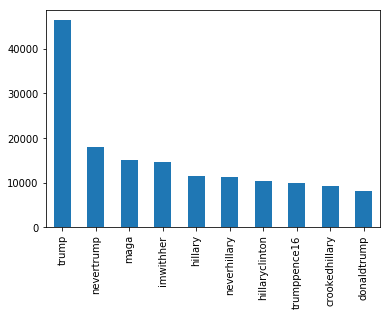

In [52]:
hashtag_count.head(10).plot(kind='bar')
plt.show()

* In each state:

In [53]:
top_hashtag = pd.Series(name='top_hashtag')
for state in state_abbr_to_name.keys():
    htstate = tweets[tweets['state']==state]['hashtags']
    temp = pd.Series(list(chain.from_iterable(htstate.values)))
    top_hashtag.ix[state] = temp.value_counts().sort_values(ascending=False).index[0]
    #top_hashtag.ix[state] = temp.value_counts().sort_values(ascending=False)[0]

/home/antonis/anaconda2/envs/USelections/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [54]:
state_data.columns

Index([u'POPULATION2016', u'males', u'females', u'nr_tweets', u'avg_age',
       u'geometry', u'tweets_per_capita', u'non_white_popul',
       u'Education_score'],
      dtype='object')

In [56]:
# state_data = state_data.drop(0,axis=1)
# #state_data.drop('top_hashtag',axis=1,inplace=True)

In [57]:
state_data = pd.concat([state_data,top_hashtag],axis=1,join='inner')

In [58]:
state_data.head()

,POPULATION2016,males,females,nr_tweets,avg_age,geometry,tweets_per_capita,non_white_popul,Education_score,top_hashtag
AK,2880780,369588,350607,888,35.559922,(POLYGON ((-129.7193510932754 21.1139411334502...,0.000308,38.1,59.55,trump
AL,19398600,2343978,2505672,4963,38.975781,POLYGON ((-85.07006727561546 31.98070335724909...,0.000256,33.8,52.85,trump
AR,11931988,1463406,1519591,1266,38.535537,POLYGON ((-94.46169128436209 34.19676535931296...,0.000106,26.6,51.90,hillary
AZ,27647556,3426641,3485248,13406,38.507104,POLYGON ((-114.5206273030434 33.02770735822419...,0.000485,43.8,56.30,trump
CA,156365812,19358288,19733165,57675,37.405932,(POLYGON ((-121.6652203096974 38.1692853630126...,0.000369,61.5,55.95,trump


In [59]:
#export csv
#state_data.to_csv("state_data_demographics.csv")

### add top hashtag to map

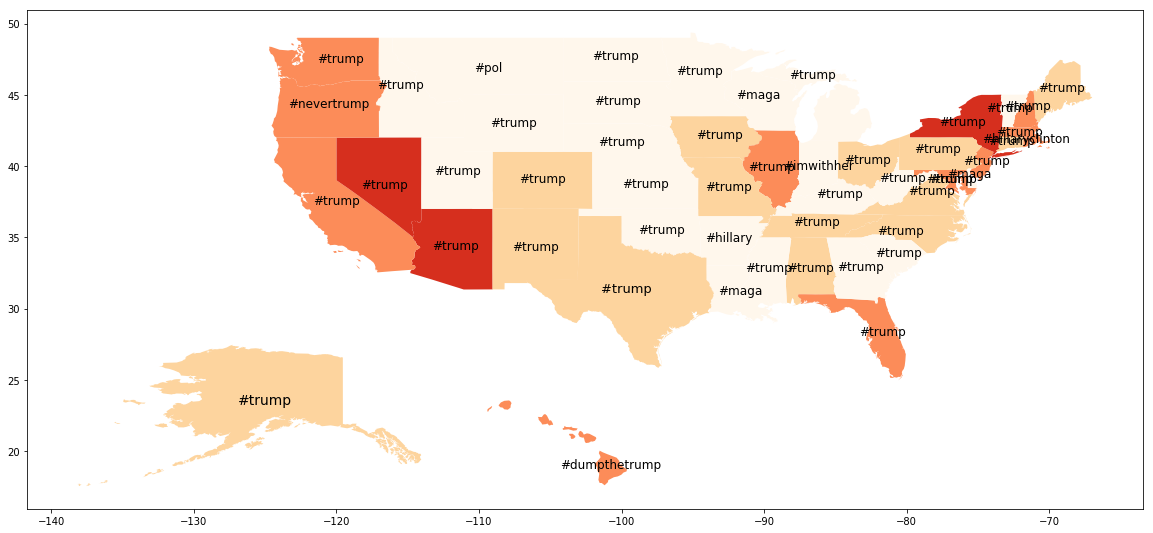

In [69]:
#credits to https://stackoverflow.com/questions/38899190/geopandas-label-polygons
state_data['coords'] = state_data['geometry'].apply(lambda x: x.representative_point().coords[:])
state_data['coords'] = [coords[0] for coords in state_data['coords']]

state_data['state_area'] = state_data['geometry'].apply(lambda x: x.area)

state_data['state_area'] = state_data['geometry'].apply(lambda x: x.area)
state_data.plot(column='tweets_per_capita',scheme = 'fisher_jenks',legend=False, cmap='OrRd',figsize=(20,10))

for idx, row in state_data.iterrows():
    plt.annotate(s='#'+row['top_hashtag'], xy=row['coords'],
                 horizontalalignment='center',size=(max(12,row.state_area/5)))
    
plt.show()

# Final objective (Research Question): 
## Correllation between Candidate Prefference and Topic Discussion 

In [72]:
topic_distribution_ps = pickle.load(open('results/topic_distribution_per_state_1.pickle'))

** Define topics **

In [73]:
from data.topics import topic_numbering

In [74]:
[topic_numbering[i] for i in range(0,10)]

['Discrimination',
 'Elections (candidacy)',
 'Lies & subjectivity',
 'Foreign affairs',
 'Elections (motivation & engagement)',
 'Elections (neutral)',
 '?',
 'Domestic policy',
 'Business & financial',
 'Weather (?)']

In [75]:
topic_distribution_ps.columns = [topic_numbering[i] for i in range(0,10)]

In [76]:
from data.US_states import regions

In [77]:
state_sentiment = pickle.load(open('results/state_sentiment_0.5.pickle'))

In [78]:
state_sentiment.head()

,T-,C+,T+,C-,N
WA,2276,1027,3150,833,2300
WI,687,331,1332,286,1281
WV,291,81,430,44,161
FL,7685,3595,10974,3100,9331
WY,51,56,119,49,71


In [79]:
state_sentiment.head()

,T-,C+,T+,C-,N
WA,2276,1027,3150,833,2300
WI,687,331,1332,286,1281
WV,291,81,430,44,161
FL,7685,3595,10974,3100,9331
WY,51,56,119,49,71


In [80]:
#normalize values and create an overal "preference indicator"
state_sentiment['T+%'] = state_sentiment['T+']/(state_sentiment['T+']+state_sentiment['T-'])
state_sentiment['C+%'] = state_sentiment['C+']/(state_sentiment['C+']+state_sentiment['C-'])
state_sentiment['overall'] = state_sentiment['T+%']/state_sentiment['C+%']

In [81]:
state_sentiment.describe()

,T-,C+,T+,C-,N,T+%,C+%,overall
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1708.549020,830.196078,2367.372549,667.294118,1922.568627,0.585808,0.554969,1.060225
std,2498.403181,1160.520418,3417.309076,931.886802,2717.523522,0.032751,0.037646,0.092338
min,51.000000,27.000000,74.000000,25.000000,43.000000,0.522616,0.463768,0.841805
25%,397.000000,227.000000,521.000000,154.000000,461.500000,0.567418,0.537760,1.015867
50%,715.000000,399.000000,1264.000000,312.000000,1036.000000,0.579509,0.554622,1.045414
75%,1938.000000,976.000000,2621.000000,842.500000,2158.000000,0.595057,0.567915,1.095017
max,13842.000000,6388.000000,18079.000000,5082.000000,14284.000000,0.700000,0.688564,1.312500


In [82]:
#investigate topic1 (racism)
df = topic_distribution_ps.merge(state_sentiment[['T+%','C+%','overall']],right_index=True,left_index=True)

In [83]:
df.drop(['?','Weather (?)'],axis=1,inplace=True)

In [84]:
df['region'] = map(lambda x: regions[x] ,df.index)

In [85]:
df.head()

,Discrimination,Elections (candidacy),Lies & subjectivity,Foreign affairs,Elections (motivation & engagement),Elections (neutral),Domestic policy,Business & financial,T+%,C+%,overall,region
WA,0.113643,0.099812,0.156283,0.082982,0.139695,0.095433,0.098087,0.092821,0.580538,0.552151,1.051413,West
WI,0.108669,0.096429,0.140538,0.079646,0.131441,0.098231,0.099067,0.094040,0.659733,0.536467,1.229773,Midwest
WV,0.107000,0.098164,0.161156,0.078603,0.133890,0.107127,0.097610,0.095808,0.596394,0.648000,0.920361,South
FL,0.112528,0.099567,0.157599,0.080494,0.136601,0.096446,0.098620,0.095940,0.588134,0.536968,1.095288,South
WY,0.113530,0.110179,0.141334,0.079651,0.126768,0.097114,0.092637,0.110225,0.700000,0.533333,1.312500,West


In [86]:
import seaborn as sns

*** Correllate topic: racism with politics ***

In [87]:
topic_distribution_ps_clean = topic_distribution_ps.drop(['?','Weather (?)'],axis=1)

In [88]:
topic_distribution_ps_clean.head()

,Discrimination,Elections (candidacy),Lies & subjectivity,Foreign affairs,Elections (motivation & engagement),Elections (neutral),Domestic policy,Business & financial
WA,0.113643,0.099812,0.156283,0.082982,0.139695,0.095433,0.098087,0.092821
WI,0.108669,0.096429,0.140538,0.079646,0.131441,0.098231,0.099067,0.094040
WV,0.107000,0.098164,0.161156,0.078603,0.133890,0.107127,0.097610,0.095808
FL,0.112528,0.099567,0.157599,0.080494,0.136601,0.096446,0.098620,0.095940
WY,0.113530,0.110179,0.141334,0.079651,0.126768,0.097114,0.092637,0.110225


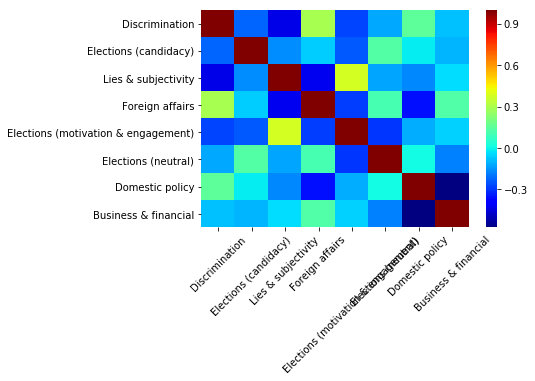

In [89]:
sns.heatmap(topic_distribution_ps_clean.corr(),cmap='jet',)
plt.xticks(rotation=45)
plt.title("")

In [90]:
df.to_csv(open('maarten/df_topics_and_sentiment_per_state.csv','wb'))

In [91]:
import numpy as np

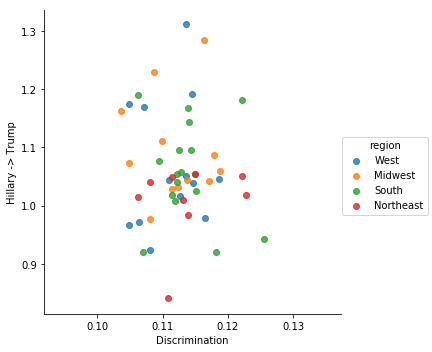

In [92]:
sns.lmplot('Discrimination','overall',df,fit_reg=False,hue='region')
plt.ylabel("Hillary -> Trump")
plt.show()

In [96]:
df.columns

Index([u'Discrimination', u'Elections (candidacy)', u'Lies & subjectivity',
       u'Foreign affairs', u'Elections (motivation & engagement)',
       u'Elections (neutral)', u'Domestic policy', u'Business & financial',
       u'T+%', u'C+%', u'overall', u'region'],
      dtype='object')

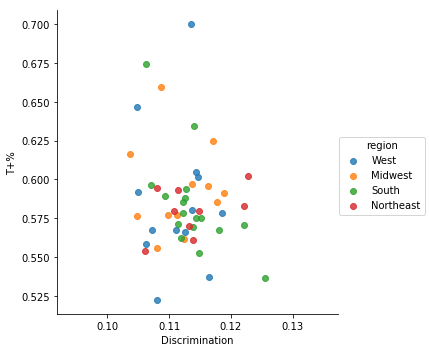

In [97]:
sns.lmplot('Discrimination','T+%',df,fit_reg=False,hue='region')
plt.show()

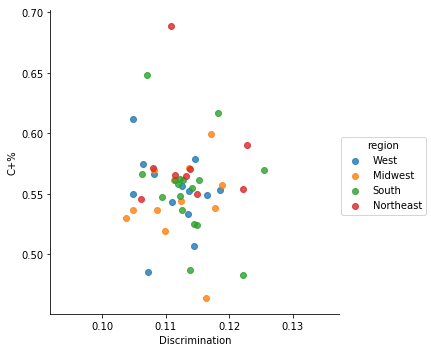

In [98]:
sns.lmplot('Discrimination','C+%',df,fit_reg=False,hue='region')
plt.show()

In [95]:
# Result: maybe clinton supporters talk/critisize about racism a lot?

** Correllate topic: Financial with supporters **

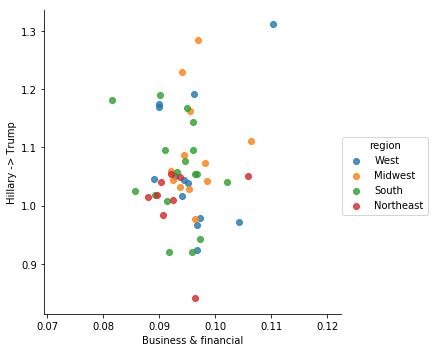

In [112]:
sns.lmplot('Business & financial','overall',df,fit_reg=False,hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

** Correllate topic: Foreign Affairs with supporters **

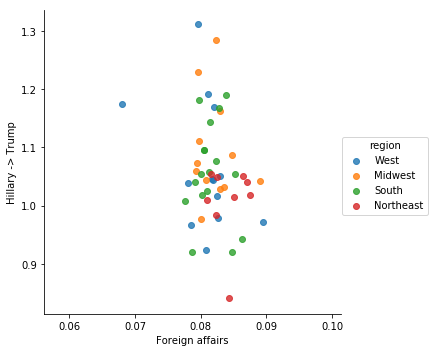

In [115]:
sns.lmplot('Foreign affairs','overall',df,fit_reg=False,hue='region')#hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

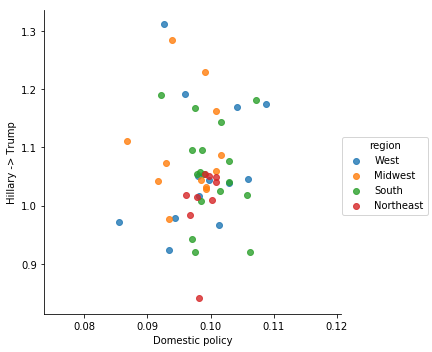

In [129]:
sns.lmplot('Domestic policy','overall',df,fit_reg=False,hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

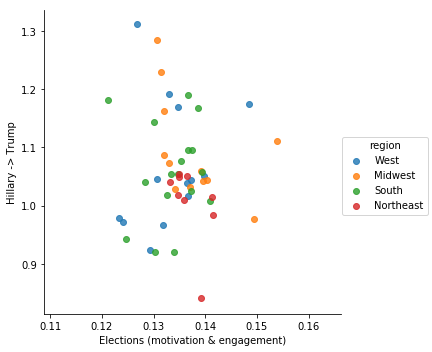

In [137]:
sns.lmplot('Elections (motivation & engagement)','overall',df,fit_reg=False,hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

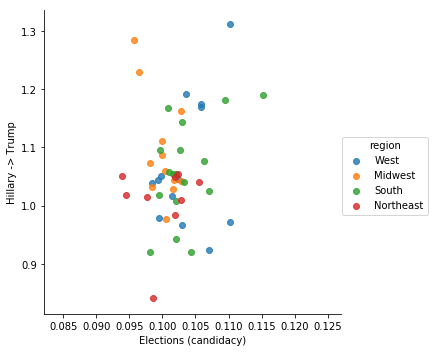

In [138]:
sns.lmplot('Elections (candidacy)','overall',df,fit_reg=False,hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

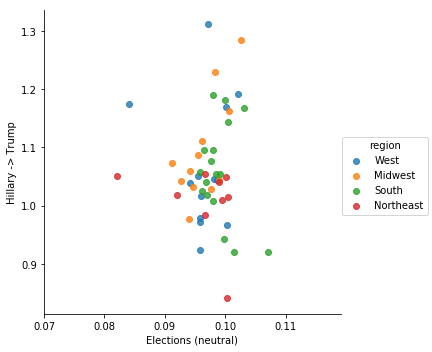

In [139]:
sns.lmplot('Elections (neutral)','overall',df,fit_reg=False,hue='region',)
plt.ylabel("Hillary -> Trump")
plt.show()

** Topics of discussion per state **

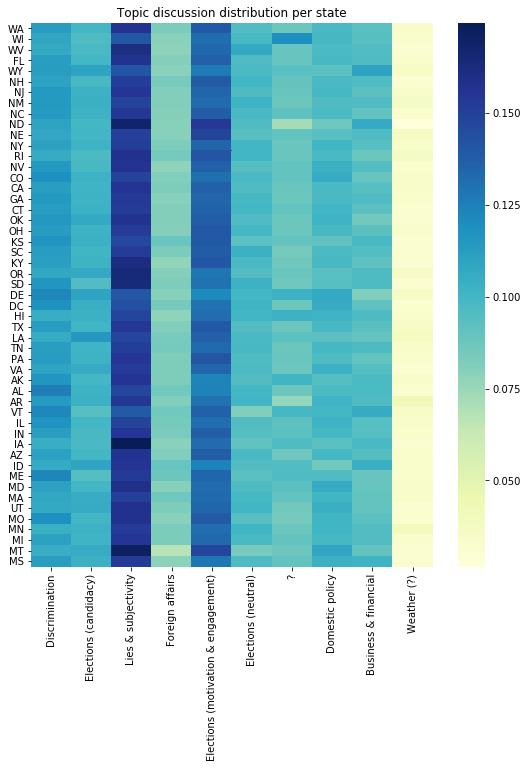

In [99]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 10))
sns.heatmap(topic_distribution_ps, annot=False, ax=ax, cmap="YlGnBu")
plt.title("Topic discussion distribution per state")
plt.show()

In [100]:
topic_distribution_ps.head()
topic_distribution_ps['region'] = df['region'].copy()

In [101]:
topic_distribution_ps_clean.columns

Index([u'Discrimination', u'Elections (candidacy)', u'Lies & subjectivity',
       u'Foreign affairs', u'Elections (motivation & engagement)',
       u'Elections (neutral)', u'Domestic policy', u'Business & financial'],
      dtype='object')

In [102]:
topic_elections = topic_distribution_ps_clean[['Discrimination', u'Elections (candidacy)', u'Lies & subjectivity','Elections (motivation & engagement)',
       u'Elections (neutral)']]

In [103]:
topic_affairs = topic_distribution_ps[['Foreign affairs','Domestic policy','Business & financial']]

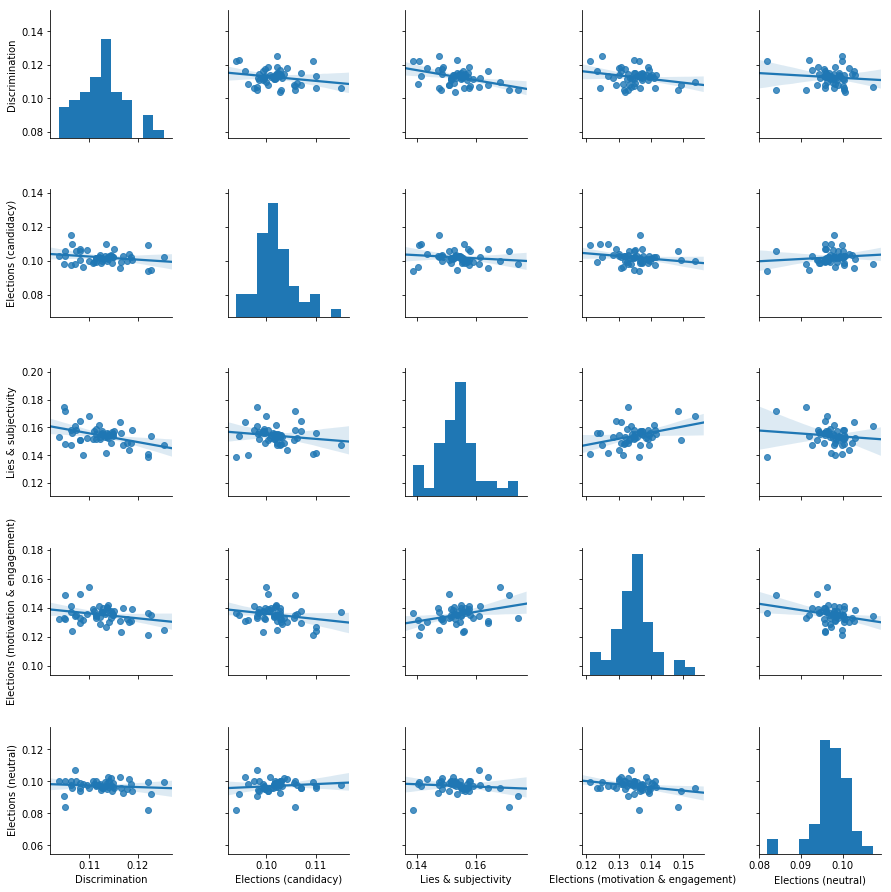

In [156]:
sns.pairplot(topic_elections,kind='reg',)#hue='region')
plt.show()

### Drop irrelevant/unimportant topics

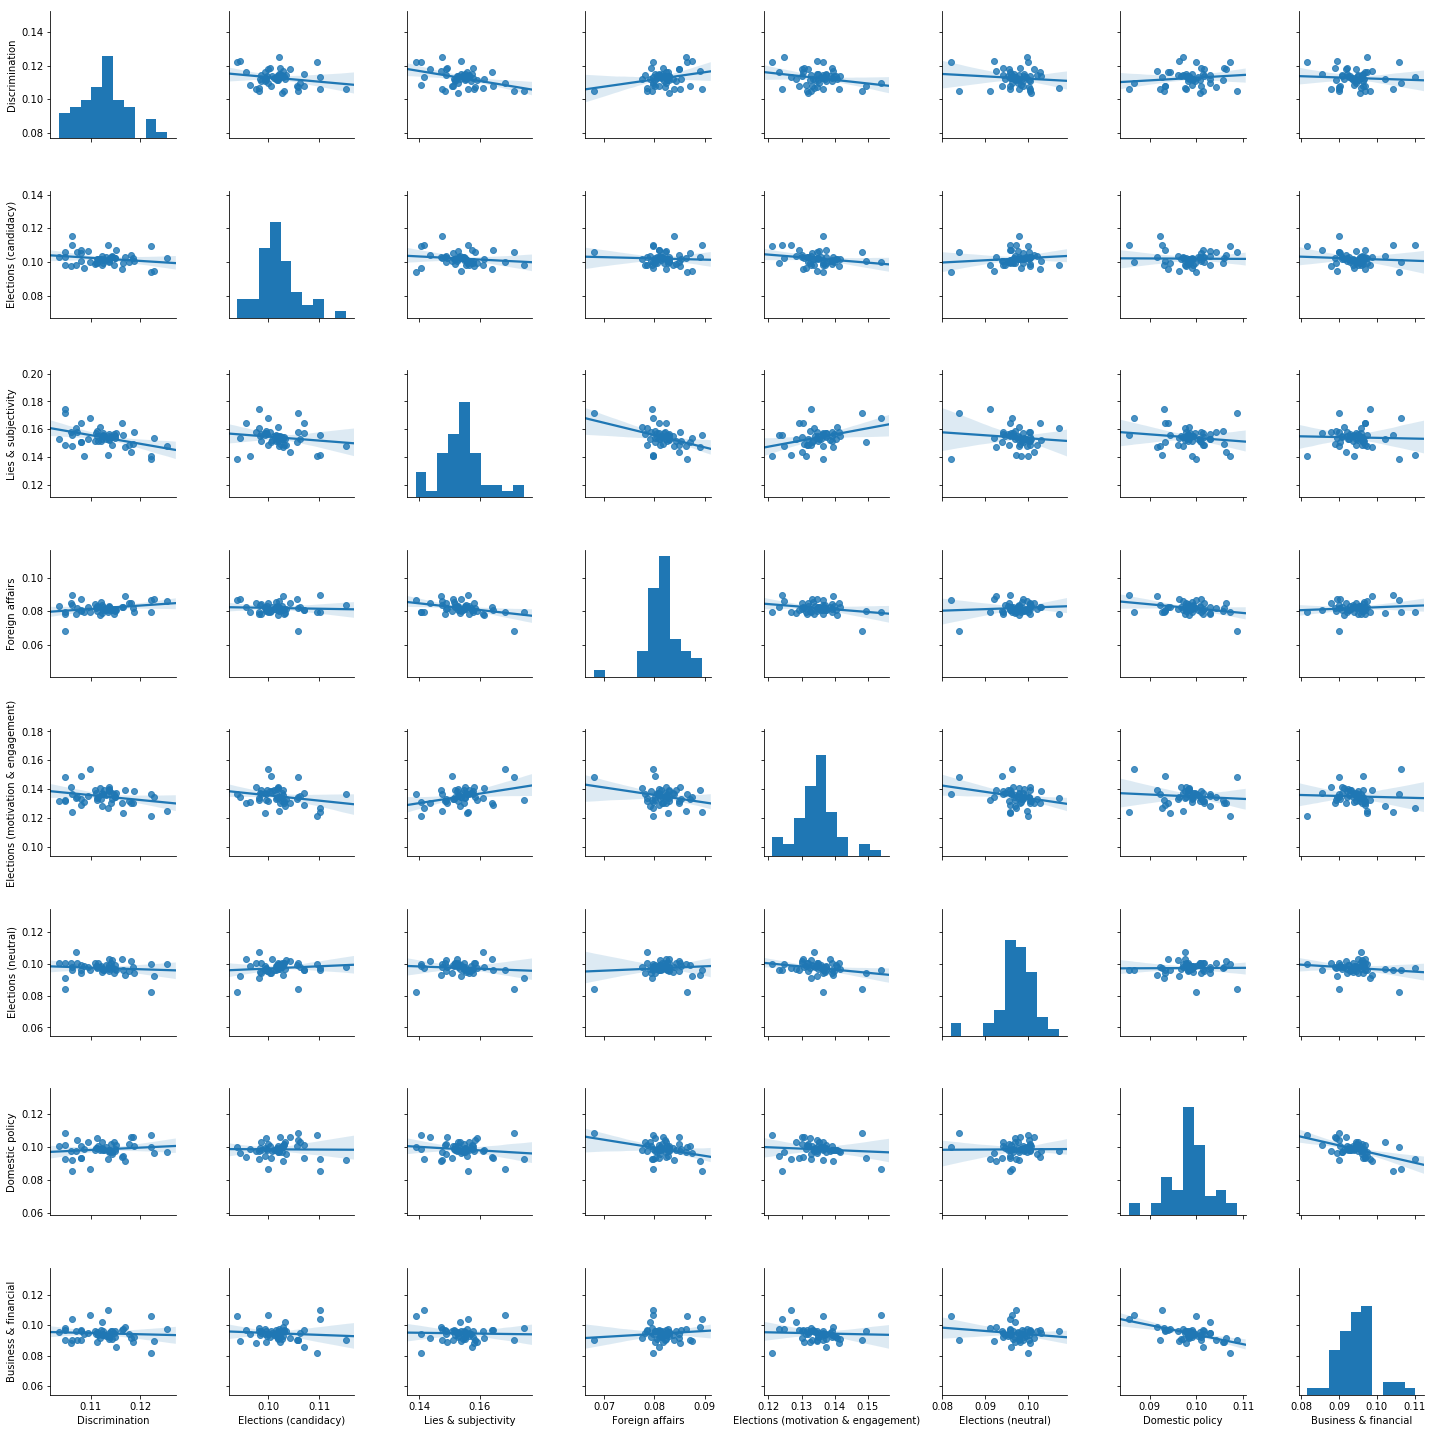

In [143]:
sns.pairplot(topic_distribution_ps_clean,kind='reg',)

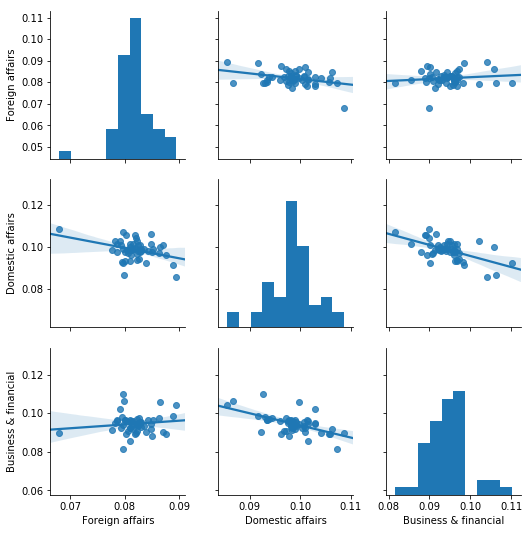

In [264]:
sns.pairplot(topic_affairs,kind='reg',)#hue='region')
plt.show()

###  We can see that domestic affairs & Financial topics have a negative correlation. It is natural for some of our topics to have negative correllation, as the total percentage of topics discussed per state should sum to 100%

### For more insights/explanations, please refer to [the original report](https://github.com/littlewine/USelections2016/blob/master/FDS_G15_Week2-3.pdf)